In [1]:
#importing 21cmFast and other relevant libraries
# https://github.com/21cmfast/21cmFAST
# https://21cmfast.readthedocs.io/en/latest/installation.html

import py21cmfast as p21c
from py21cmfast import plotting
from py21cmfast import cache_tools

import matplotlib.pyplot as plt
import logging, sys, os, numpy as np
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

from utils import *

/home/akbro_10/.local/lib/python3.8/site-packages/py21cmfast/_cfg.py:57: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/akbro_10/.local/lib/python3.8/site-packages/py21cmfast/_cfg.py:41: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [2]:
#importing tools21cm and other relevant libraries
# https://github.com/sambit-giri/tools21cm

import tools21cm as t2c

import numpy as np, matplotlib.pyplot as plt
from scipy import fftpack, stats
from numpy import pi
import warnings
warnings.filterwarnings("ignore")

In [3]:
print("Cosmological Parameters default =",p21c.CosmoParams._defaults_)
print("Astrophysical Parameters default =",p21c.AstroParams._defaults_)

Cosmological Parameters default = {'SIGMA_8': 0.8102, 'hlittle': 0.6766, 'OMm': 0.30964144154550644, 'OMb': 0.04897468161869667, 'POWER_INDEX': 0.9665}
Astrophysical Parameters default = {'HII_EFF_FACTOR': 30.0, 'F_STAR10': -1.3, 'F_STAR7_MINI': -2.0, 'ALPHA_STAR': 0.5, 'ALPHA_STAR_MINI': 0.5, 'F_ESC10': -1.0, 'F_ESC7_MINI': -2.0, 'ALPHA_ESC': -0.5, 'M_TURN': 8.7, 'R_BUBBLE_MAX': None, 'ION_Tvir_MIN': 4.69897, 'L_X': 40.0, 'L_X_MINI': 40.0, 'NU_X_THRESH': 500.0, 'X_RAY_SPEC_INDEX': 1.0, 'X_RAY_Tvir_MIN': None, 'F_H2_SHIELD': 0.0, 't_STAR': 0.5, 'N_RSD_STEPS': 20, 'A_LW': 2.0, 'BETA_LW': 0.6, 'A_VCB': 1.0, 'BETA_VCB': 1.8}


In [4]:
z = np.arange(6, 16, 2)
print(z)
c = ['b', 'g', 'y', 'orange', 'r']

zs = np.arange(5, 15, 0.5)


[ 6  8 10 12 14]


In [5]:
# Brightness temperature function

def brightness_temperature(box, redshift, hubble=None, matter=None):
    initial_conditions = p21c.initial_conditions(
        user_params = {"HII_DIM": box, "BOX_LEN": box},
        cosmo_params = p21c.CosmoParams(SIGMA_8=0.8, hlittle=hubble, OMm=matter),
        random_seed=54321
    )

    perturbed_field = p21c.perturb_field(
        redshift = redshift,
        init_boxes = initial_conditions
    )

    ionized_field = p21c.ionize_box(
        perturbed_field = perturbed_field
    )

    brightness_temp = p21c.brightness_temperature(ionized_box=ionized_field, perturbed_field=perturbed_field)

    return brightness_temp

In [6]:
def ps1d(cube, kbins=15):
    H = 67.66  
    h = H/100.
    dim = 100.

    box_dims = [dim]*len(cube.shape)

    ft = fftpack.fftshift(fftpack.fftn(cube.astype('float64')))
    
    power_spectrum = np.abs(ft)**2
    
    boxvol = np.product(box_dims)
    pixelsize = boxvol/(np.product(cube.shape))
    
    power_spectrum *= pixelsize**2/boxvol

    ps, ks, n_modes = radial_average(power_spectrum, kbins=kbins, box_dims=box_dims, binning='log', breakpoint=0.1)
    return ks, ps*ks**3/2/pi**2

In [7]:
Yf = np.array([brightness_temperature(box=50, redshift=i).brightness_temp for i in z])

Yh = np.array([brightness_temperature(box=50, redshift=i, hubble=0.80).brightness_temp for i in z])

Ym = np.array([brightness_temperature(box=50, redshift=i, matter=0.4).brightness_temp for i in z])

Ya = np.array([brightness_temperature(box=50, redshift=i,hubble=0.80,matter=0.4).brightness_temp for i in z])

In [8]:
Yfs = np.array([brightness_temperature(box=50, redshift=i).brightness_temp for i in zs])

Yhs = np.array([brightness_temperature(box=50, redshift=i, hubble=0.80).brightness_temp for i in zs])

Yms = np.array([brightness_temperature(box=50, redshift=i, matter=0.4).brightness_temp for i in zs])

Yas = np.array([brightness_temperature(box=50, redshift=i,hubble=0.80,matter=0.4).brightness_temp for i in zs])

In [9]:
scale_Yf, power_Yf = [], []

for i,ii in enumerate(z):
    ks, ps = ps1d(Yf[i,...])
    scale_Yf.append(ks); power_Yf.append(ps)
    
scale_Yh, power_Yh = [], []

for i,ii in enumerate(z):
    ks, ps = ps1d(Yh[i,...])
    scale_Yh.append(ks); power_Yh.append(ps)
    
scale_Ym, power_Ym = [], []

for i,ii in enumerate(z):
    ks, ps = ps1d(Ym[i,...])
    scale_Ym.append(ks); power_Ym.append(ps)
    
scale_Ya, power_Ya = [], []

for i,ii in enumerate(z):
    ks, ps = ps1d(Ya[i,...])
    scale_Ya.append(ks); power_Ya.append(ps)    

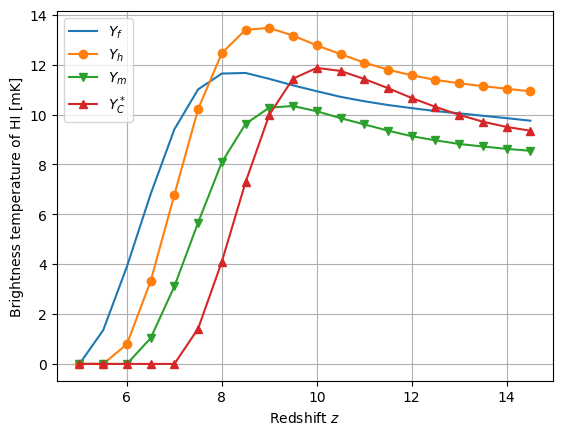

In [89]:
plt.plot(zs, np.std(Yfs, axis=(1,2,3)), '-', label='$Y_f$')
plt.plot(zs, np.std(Yhs, axis=(1,2,3)),'o-', label='$Y_h$')
plt.plot(zs, np.std(Yms, axis=(1,2,3)),'v-', label='$Y_m$')
plt.plot(zs, np.std(Yas, axis=(1,2,3)), '^-',label='$Y_C^*$')

plt.xlabel('Redshift $z$')
plt.ylabel('Brightness temperature of HI [mK]')
plt.legend()
plt.grid()
plt.savefig('SpectrumCosmoparam.pdf')

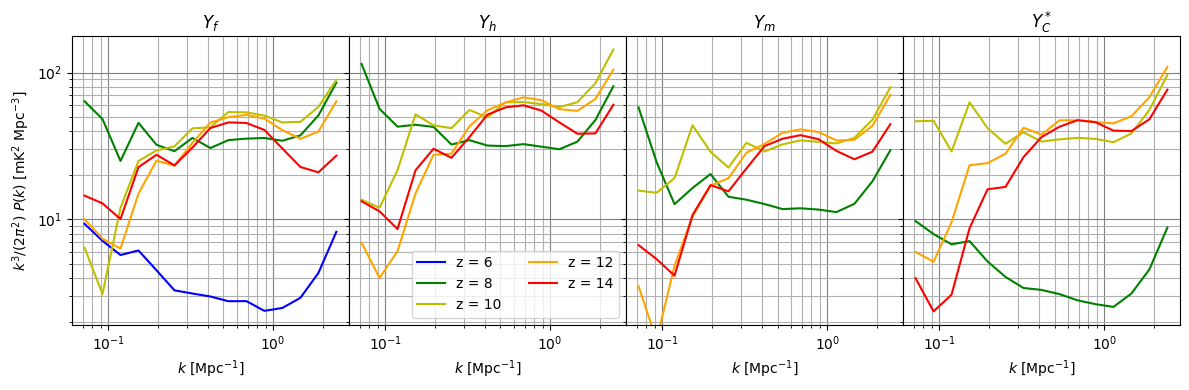

In [20]:
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

scale, power = [scale_Yf, scale_Yh, scale_Ym, scale_Ya], [power_Yf, power_Yh, power_Ym, power_Ya]
titles = ['$Y_f$', '$Y_h$', '$Y_m$','$Y_C^*$']

for i, ii in enumerate(z):
    for j,jj in enumerate(ax):
        jj.loglog(scale[j][i], power[j][i], '-', color=c[i], label='z = %i'%z[i])
        jj.set_xlabel('$k$ [Mpc$^{-1}$]')
        jj.grid(True, which='major', color='grey')
        jj.grid(True, which='minor')
        jj.set_title(titles[j], ha='center');
        if j==1: jj.legend(ncol=2);
        
ax[0].set_ylabel('$k^3/(2\pi^2)\ P(k)$ [mK$^2$ Mpc$^{-3}$]')

plt.tight_layout()
plt.savefig('PSvskCosmoparam.pdf')

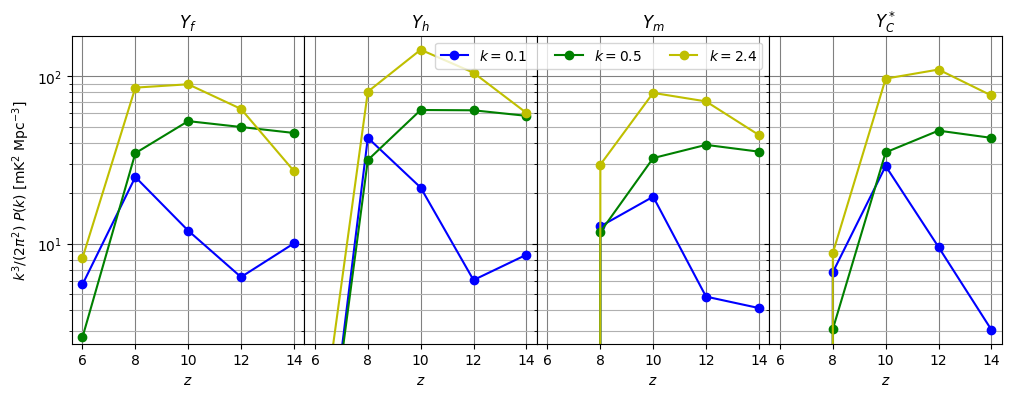

In [17]:
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ind = [2, 8, 14]
scale = scale_Yf[0][ind]

power = np.array([np.array(power_Yf), np.array(power_Yh), np.array(power_Ym), np.array(power_Ya)])


for i, ii in enumerate(ind):
    for j,jj in enumerate(ax):
        jj.semilogy(z, power[j, :, ii], 'o-', color=c[i], label='$k = %.1f$'%scale[i])
        jj.set_xlabel('$z$')
        jj.grid(True, which='major', color='grey')
        jj.grid(True, which='minor')
        if j==2: jj.legend(ncol=3)
        jj.set_title(titles[j], ha='center') 
        
ax[0].set_ylabel('$k^3/(2\pi^2)\ P(k)$ [mK$^2$ Mpc$^{-3}$]')

plt.savefig('PSvszCosmoparam.pdf')

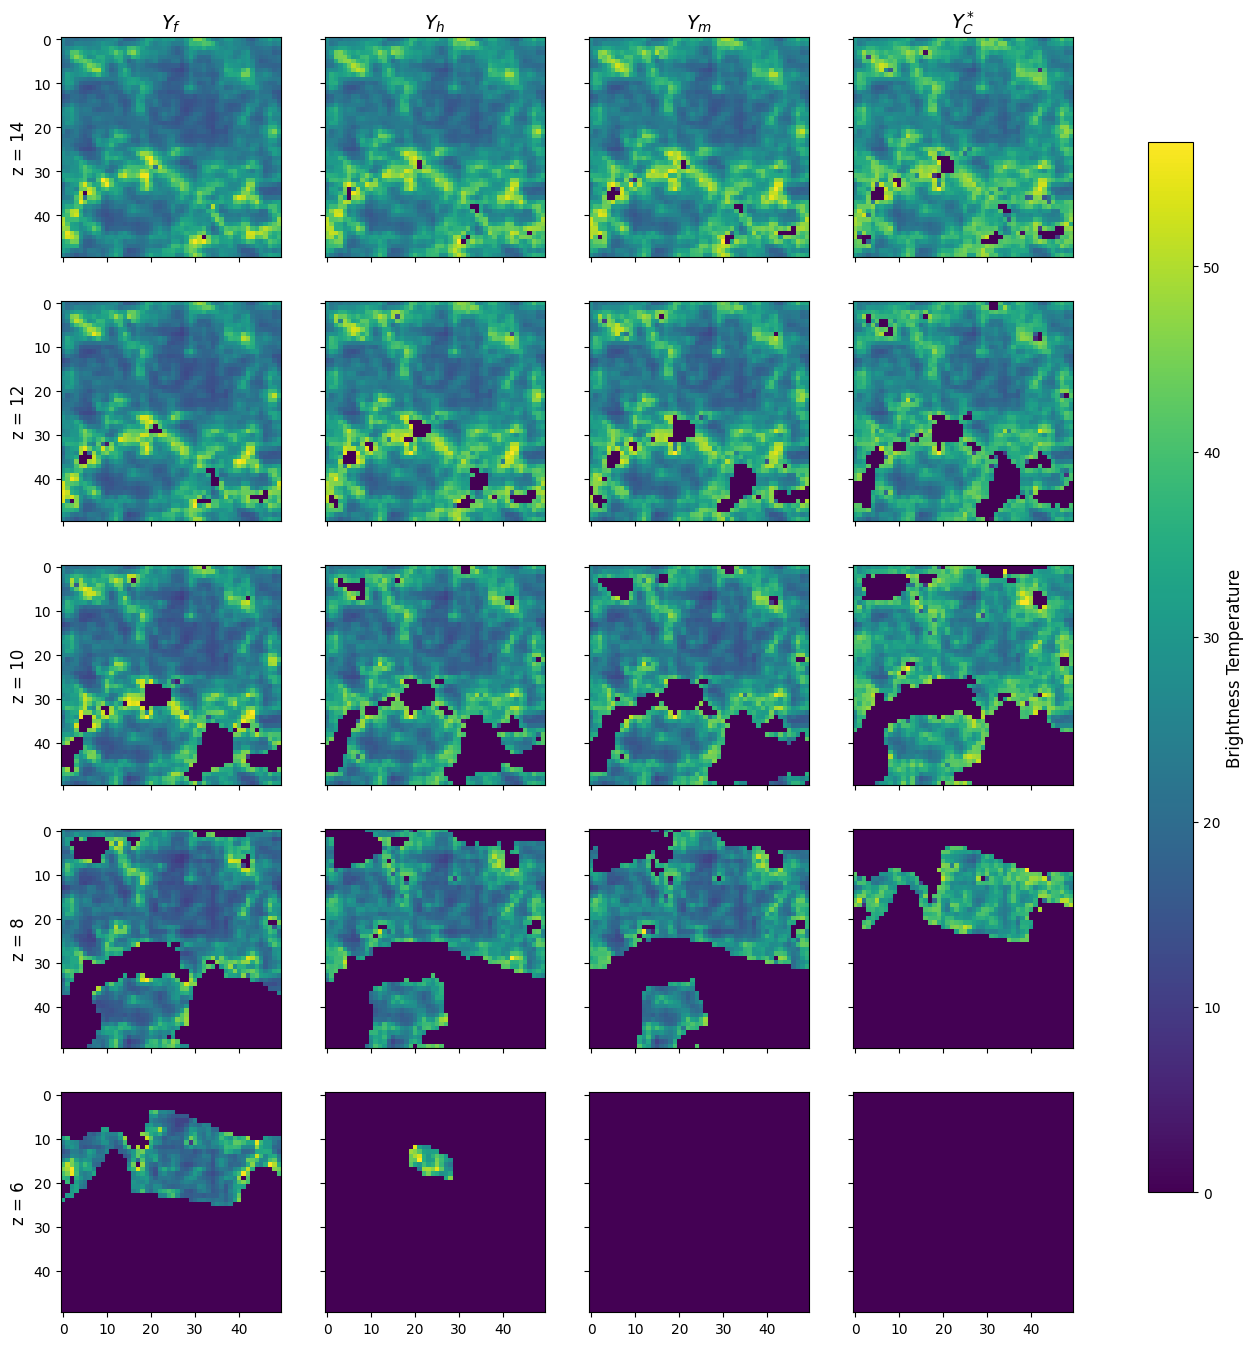

In [88]:
import matplotlib.pyplot as plt

# Assuming Yf, Yh, Ym, and Ya are 4D arrays where the first dimension corresponds to redshift
# and the last dimension is not relevant for visualization
# The shape of each array is (n_redshifts, n_x, n_y, n_a)

fig, axs = plt.subplots(5, 4, figsize=(15, 15), sharex='col', sharey='row')  # Create a figure with 5 rows and 4 columns of subplots

# Reverse the order of redshifts
z_reversed = z[::-1]

zlabel = ['z = 6','z = 8','z = 10','z = 12','z = 14']
# Iterate over each reversed redshift index
for i, redshift_idx in enumerate(range(4, -1, -1)):
    redshift = z_reversed[i]

    # Plot Yf
    im1 = axs[redshift_idx, 0].imshow(Yf[i, :, :, 0])
    axs[redshift_idx, 0].set_ylabel(zlabel[i], fontsize=12)

    # Plot Yh
    im2 = axs[redshift_idx, 1].imshow(Yh[i, :, :, 0])

    # Plot Ym
    im3 = axs[redshift_idx, 2].imshow(Ym[i, :, :, 0])

    # Plot Ya
    im4 = axs[redshift_idx, 3].imshow(Ya[i, :, :, 0])

# Set titles for each model (column)
for j, model_title in enumerate(['$Y_f$', '$Y_h$', '$Y_m$', '$Y_C^*$']):
    axs[0, j].set_title(model_title, fontsize=14)


# Adjust layout to accommodate the colorbar at the bottom
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.95)

# Add a single colorbar at the bottom
cax = fig.add_axes([0.85, 0.18, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im4, cax=cax, orientation='vertical')
cbar.set_label('Brightness Temperature', fontsize=12)


plt.savefig('BTCubeCosmoparams.pdf')